# Regression analysis - Sharechat annotated claims dataset

Research - https://arxiv.org/abs/2010.13387

### Steps

1. Loading and combining annotated data files
2. Engineering new features using Optical Character Recognition, Named Entity Recognition etc
3. Train test split 
4. Missing value imputation
5. Standardizing numeric variables
6. Dummifying categorical variables
7. Building and evaluating a logistic regression model
8. Plotting learning curves and comparing with other models

In [406]:
import sys
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import os
import numpy as np
import re
import string
from pprint import pprint
import json
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import random
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import requests
import logging
from datetime import datetime, timedelta
import time
import spacy
nlp = spacy.load("en_core_web_sm")
from googletrans import Translator
import time
from time import perf_counter
from random import uniform
import emoji
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
pd.options.mode.chained_assignment = None
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import to_graphviz
from sklearn.tree import export_graphviz
import scipy
from google.cloud import translate_v2 as translate
import wget
from google.cloud import vision
from google.protobuf.json_format import MessageToJson
import requests
from PIL import Image
import io
from io import BytesIO

## Load data

In [505]:
ind = pd.read_csv(os.environ.get("ANNOTATION_IND"))
group1 = pd.read_csv(os.environ.get("ANNOTATION_GRP1"))
group2 = pd.read_csv(os.environ.get("ANNOTATION_GRP2"))

In [506]:
df = ind.append(group1).append(group2)

In [507]:
df.reset_index(drop=True, inplace=True)

In [508]:
df.to_csv("sharechat_annotated_zenodo.csv")

In [509]:
def claims(data):
    if "Yes" in str(data):
        return 1
    else:
        return 0

In [510]:
df["claim"] = df["verifiable_claim"].map(claims)

In [511]:
df.drop(["annotator_label", "_id", "verifiable_claim"], axis=1, inplace=True)

## Feature Engineering

1. Number of hashtags
2. Hour of day bins
3. Number of words in text / extracted text
4. Named entities in text (whether present or not)

In [512]:
def count_hashtags(data):
    return len(re.findall("#", str(data)))

In [513]:
df["n_hashtags"] = df["caption"].map(count_hashtags)

In [514]:
df["datetime"] = pd.to_datetime(df["timestamp"])

In [515]:
def hour(data):
    time = data.time()
    hour_string = str(time)[:2]
    hour_int = int(hour_string) 
    return hour_int

In [516]:
df["hour"] = df["datetime"].map(hour)

In [517]:
images_df=df[df["media_type"]=="image"]
print(len(images_df))

1372


In [518]:
images_df["s3_url"] = "https://s3.ap-south-1.amazonaws.com/sharechat-scraper.tattle.co.in/" + images_df["filename"] + ".jpg"

In [519]:
# %%time
# for i in images_df["s3_url"]:
#     wget.download(i, out="images/")

In [520]:
# %%time
# f=0
# extractions = {}
# texts = []
# client = vision.ImageAnnotatorClient()
# img_folder = os.getcwd() + "/images"
# for i in os.listdir(img_folder):
#     if i != '.DS_Store':
#         path = os.getcwd() + "/images/" + i
#         with io.open(path, 'rb') as image_file:
#             content = image_file.read()
#         image = vision.Image(content=content)
#         try:
#             resp = client.text_detection(image=image)
#             text = resp.full_text_annotation.text
#             extractions[i] = text
#             texts.append(text)
#         except Exception:
#             f+=1
#             extractions[i] = ''
#             texts.append("")

In [521]:
# with open("extractions.json","w") as f:
#     json.dump(extractions, f)

In [522]:
# Load previously extracted image text
with open("extractions.json","r") as f:
    extractions = json.loads(f.read())

In [523]:
def match_texts(filename):
    text = extractions.get(filename+".jpg")
    return text

In [524]:
# Extract text from images
df["extracted_text"] = df["filename"].map(match_texts)

In [525]:
def remove_newlines(data):
    if data != None:
        return re.sub("\n", " ", data)
    else:
        return None

In [526]:
df["extracted_text"] = df["extracted_text"].map(remove_newlines)

In [527]:
# Replace nans and Nones with blank strings
df["extracted_text"] = np.where(df["extracted_text"]!=df["extracted_text"], "", df["extracted_text"])
df["text"] = np.where(df["text"]!=df["text"], "", df["text"])

In [529]:
df["combined_text"] = df["extracted_text"] + df["text"]

In [532]:
def count_words(data):
    if data == data:
        wordlist = data.split(" ")
        if len(data) > 0:
            return(len(wordlist))
        else:
            return 0
    else:
        return 0

In [533]:
df["n_words"] = df["combined_text"].map(count_words)

In [534]:
# Fix bad label
df["contains_image"] = np.where(df["contains_image"] == "Does no contain human(s)", "Does not contain human(s)", df["contains_image"])

In [537]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

In [538]:
df["combined_text"] = df["combined_text"].map(remove_emoji)

In [567]:
translator = translate.Client()

In [575]:
def translate_text(text):
    text = translate_client.translate(text).get("translatedText", "")
    return text

In [577]:
start = perf_counter()
df["translation"] = df["combined_text"].map(translate_text)
delta = perf_counter() - start
print(delta)

324.179788008998


In [629]:
def get_entities(text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
#         if ent.label_ in ["PERSON", "NORP", "ORG", "GPE"]:
        entities.append(ent.text)
    return entities

In [630]:
df["named_entities"] = df["translation"].map(get_entities)

In [631]:
df["entities_count"] = df["named_entities"].map(len)

In [633]:
drop_cols = [
        "tag_name", "tag_translation", "timestamp", 
        "caption", "text", "filename",
        "datetime", "extracted_text", "named_entities"]

## Preprocessing

In [684]:
# Train test split
X = df.drop("claim", axis=1)
y = df["claim"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [685]:
def prepare_data(df):
    # Drop columns that won't be used 
    df.drop(drop_cols, axis=1, inplace=True)
    return df

In [686]:
X_train = prepare_data(X_train)

In [687]:
# Count missing values in each column
X_train.isna().sum()

bucket_name                0
external_shares            0
likes                      0
media_type                 0
contains_video            29
contains_image            28
visible_source            29
contains_relevant_meme    28
n_hashtags                 0
hour                       0
combined_text              0
n_words                    0
translation                0
entities_count             0
dtype: int64

In [688]:
# Impute nans in categorical columns
imputer = SimpleImputer(strategy="most_frequent")

In [689]:
columns = X_train.columns
X_train = pd.DataFrame(imputer.fit_transform(X_train))
X_train.columns = columns

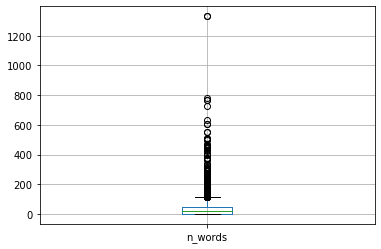

In [690]:
# Inspect numeric variables for outliers
df.boxplot(column="n_words")

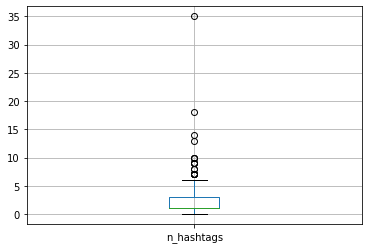

In [691]:
df.boxplot(column="n_hashtags")

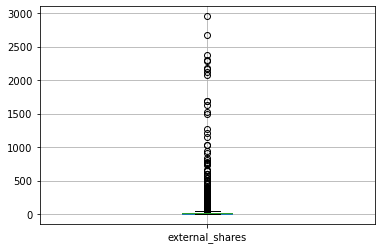

In [692]:
df.boxplot(column="external_shares")

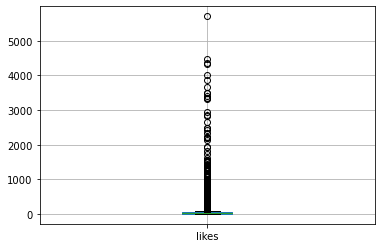

In [693]:
df.boxplot(column="likes")

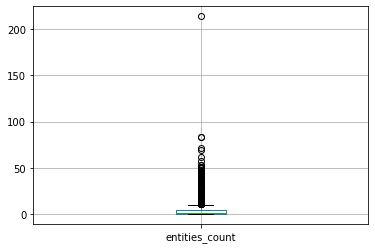

In [694]:
df.boxplot(column="entities_count")

In [695]:
# Standardize numeric variables
scaler = StandardScaler()
num = ["n_words", "n_hashtags", "likes", "external_shares", "entities_count"]
num_cols = pd.DataFrame(scaler.fit_transform(X_train[num]))
num_cols.columns = num

In [696]:
# Convert categorical columns
cat = [
    "media_type", "contains_video", "contains_image", 
    "visible_source", "contains_relevant_meme", "bucket_name", "hour"]
X_train[cat] = X_train[cat].apply(pd.Categorical)

In [697]:
# Dummify categorical columns
cat_cols = pd.get_dummies(X_train[cat], drop_first = True)

In [698]:
X_train = pd.concat([cat_cols, num_cols], axis=1)

In [699]:
# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

In [700]:
# Apply preprocessing to test set
X_test = prepare_data(X_test)

columns = X_test.columns
X_test = pd.DataFrame(imputer.transform(X_test))
X_test.columns = columns

num_cols = pd.DataFrame(scaler.transform(X_test[num]))
num_cols.columns = num

X_test[cat] = X_test[cat].apply(pd.Categorical)

cat_cols = pd.get_dummies(X_test[cat], drop_first = True)
X_test = pd.concat([cat_cols, num_cols], axis=1)

y_test = label_encoder.transform(y_test)

In [701]:
# Defining a function to fix column difference between train and test sets

# This will go inside the main function
def add_missing_dummy_columns(test_set, train_columns):
    # d = test set, columns = train set columns 
    missing_cols = set(train_columns) - set(test_set.columns)
    for c in missing_cols:
        test_set[c] = 0 # add missing columns to test set with empty column values
        
# This is the main function     
def fix_columns(test_set, train_columns):  

    add_missing_dummy_columns(test_set, train_columns)

    # make sure we have all the columns we need
    assert(set(train_columns) - set(test_set.columns) == set())

    extra_cols = set(test_set.columns) - set(train_columns) # these are the extra cols in the test set
    if extra_cols:
        print ("extra columns:", extra_cols)

    test_set = test_set[train_columns] # keep only columns that are in the train set 
    return test_set


In [702]:
X_test = fix_columns(X_test, X_train.columns)

extra columns: {'bucket_name_राजनीति '}


In [703]:
# Sanity check
assert(set(X_train.columns) - set(X_test.columns) == set())

In [704]:
vifs = pd.Series(np.linalg.inv(X_train.corr().values).diagonal(), index=X_train.corr().index)

In [705]:
vifs

media_type_text                                        1.248123
media_type_video                                       2.513759
contains_video_Other                                   1.505321
contains_video_Yes, contains violent incident          1.123644
contains_video_Yes, person is performing for camera    1.915311
contains_image_Does not contain human(s)               1.210347
contains_image_No, does not contain images             1.354312
visible_source_Digital Content Providers               1.051693
visible_source_Digital Only News Outlets               1.071521
visible_source_Government/Public Authority             1.051752
visible_source_Other                                   1.064818
visible_source_Print/TV Media                          1.192653
contains_relevant_meme_Yes                             1.281150
bucket_name_ख़बरें                                     1.080695
bucket_name_ख़बरें और राजनीति                          2.401523
bucket_name_देश प्रेम                   

In [706]:
# Drop columns with high VIFs
vif_cols = ["hour_14", "hour_15", "hour_16", "hour_17", "hour_18"]
X_train.drop(vif_cols, axis=1, inplace=True)
X_test.drop(vif_cols, axis=1, inplace=True)

## Model building

In [707]:
logit_model = sm.Logit(y_train, X_train, random_state=0)
result = logit_model.fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.517225
         Iterations 25


In [708]:
print(result.summary2())

                                                     Results: Logit
Model:                                 Logit                              Pseudo R-squared:                   0.224     
Dependent Variable:                    y                                  AIC:                                1906.6331 
Date:                                  2020-11-24 10:10                   BIC:                                2141.9751 
No. Observations:                      1760                               Log-Likelihood:                     -910.32   
Df Model:                              42                                 LL-Null:                            -1173.6   
Df Residuals:                          1717                               LLR p-value:                        5.0759e-85
Converged:                             1.0000                             Scale:                              1.0000    
No. Iterations:                        25.0000                                       

In [709]:
# Keep features with significant p-values
keep = [
    "media_type_video", "contains_video_Other", "contains_video_Yes, person is performing for camera", "contains_video_Yes, contains violent incident",
    "contains_image_Does not contain human(s)", "contains_image_No, does not contain images", "visible_source_Digital Only News Outlets",
    "visible_source_Digital Content Providers", "visible_source_Government/Public Authority",
    "visible_source_Other ", "visible_source_Print/TV Media", "contains_relevant_meme_Yes", "bucket_name_ख़बरें और राजनीति", "bucket_name_ख़बरें",
    "bucket_name_देश प्रेम ", "bucket_name_स्वास्थ्य", "hour_2", "hour_3", "hour_8", "hour_10", "hour_19", "hour_20", "n_words", "likes", "external_shares", "entities_count"
]

In [710]:
X_train = X_train[keep]
X_test = X_test[keep]

In [711]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.7494318181818181
0.7113636363636363


In [712]:
# Count true / false positives / negatives
tn, fp, fn, tp = confusion_matrix(y_train, pred_train).ravel()
print(tn, fp, fn, tp)

961 120 321 358


In [713]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
print(tn, fp, fn, tp)

220 39 88 93


In [714]:
# Calculate accuracy metrics
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1081
           1       0.75      0.53      0.62       679

    accuracy                           0.75      1760
   macro avg       0.75      0.71      0.72      1760
weighted avg       0.75      0.75      0.74      1760



In [715]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       259
           1       0.70      0.51      0.59       181

    accuracy                           0.71       440
   macro avg       0.71      0.68      0.69       440
weighted avg       0.71      0.71      0.70       440



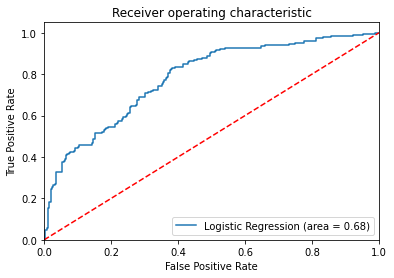

In [716]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Learning Curves & Model Comparisons

In [748]:
# Defining a function to plot a learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize = (10, 5))
    plt.title(title, fontsize = 14)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples", fontsize = 14)
    plt.ylabel("Accuracy", rotation = 90, fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(np.arange(.1, 1.0, 0.05), fontsize = 12)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid()
    return plt

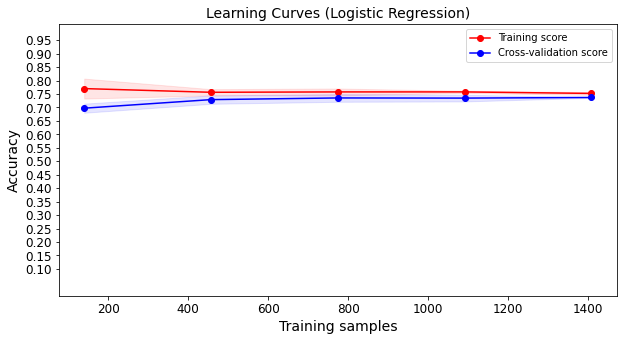

In [749]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression(random_state=0)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

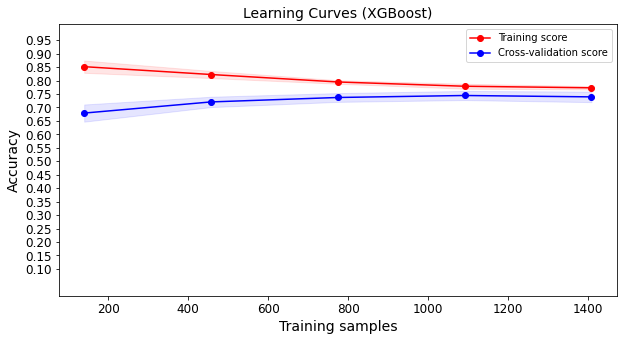

In [750]:
title = "Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = XGBClassifier(random_state=0, n_estimators=10, max_depth=3)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

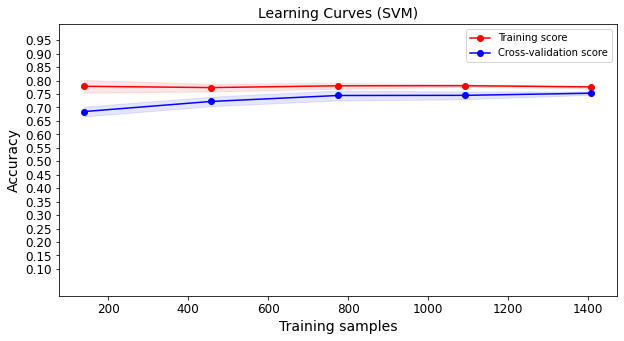

In [751]:
title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(random_state=0, C=1)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0, 1.01), cv=cv, n_jobs=1)
plt.show()

The models appear to be underfitting, which may be due to not having sufficient data to train.